In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Imports
from os.path import join
from os import makedirs
import numpy as np
import sys

rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import load_iris, make_blobs
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from gudhi.clustering.tomato import Tomato
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.cluster.hierarchy import linkage, dendrogram
from hdbscan import HDBSCAN

sys.path.append("..")
from vis_utils import configure_plotting_for_thesis

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

In [3]:
# Constants
output_dir = "output_plots"
makedirs(output_dir, exist_ok=True)
save_plots_to_file = True

<IPython.core.display.Javascript object>

## Clustering

In [4]:
# Create clustering data
clustering_dataset_X, clustering_dataset_y = make_blobs(
    n_samples=100, cluster_std=1, centers=3, random_state=399
)
true_n_clusters = len(np.unique(clustering_dataset_y))
clustering_dataset_markers = [".", "^", "D"]

<IPython.core.display.Javascript object>

In [5]:
# Create decision boundary for clustering dataset
h = 0.01
x_min, x_max = (
    clustering_dataset_X[:, 0].min() - 1,
    clustering_dataset_X[:, 0].max() + 1,
)
y_min, y_max = (
    clustering_dataset_X[:, 1].min() - 1,
    clustering_dataset_X[:, 1].max() + 1,
)
clustering_dataset_xx, clustering_dataset_yy = np.meshgrid(
    np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)
)
clustering_dataset_X_mesh = np.array(
    [clustering_dataset_xx.ravel(), clustering_dataset_yy.ravel()]
).T

<IPython.core.display.Javascript object>

### K-means clustering

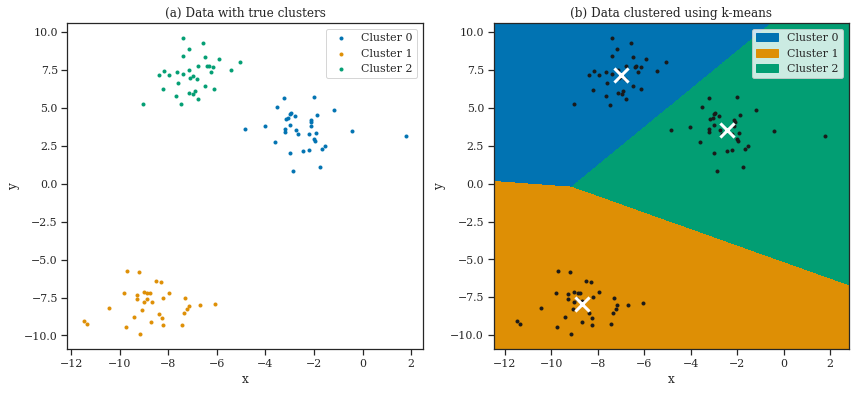

<IPython.core.display.Javascript object>

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot true
for label in range(true_n_clusters):
    point_indices = np.where(clustering_dataset_y == label)[0]

    ax1.scatter(
        x=clustering_dataset_X[point_indices, 0],
        y=clustering_dataset_X[point_indices, 1],
        label=f"Cluster {label}",
        marker=".",
    )
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("(a) Data with true clusters")

# Plot predicted
cluster_instance = KMeans(n_clusters=true_n_clusters, random_state=rng_seed)
cluster_instance.fit(clustering_dataset_X)
pred_labels_Z = cluster_instance.predict(
    np.array([clustering_dataset_xx.ravel(), clustering_dataset_yy.ravel()]).T
)
pred_labels = pred_labels_Z.reshape(clustering_dataset_xx.shape)

ax_im = ax2.imshow(
    pred_labels,
    interpolation="nearest",
    extent=(
        clustering_dataset_xx.min(),
        clustering_dataset_xx.max(),
        clustering_dataset_yy.min(),
        clustering_dataset_yy.max(),
    ),
    aspect="auto",
    origin="lower",
    cmap=ListedColormap(sns.color_palette("colorblind").as_hex(), N=true_n_clusters),
)
ax2.scatter(
    x=clustering_dataset_X[:, 0],
    y=clustering_dataset_X[:, 1],
    c="k",
    marker=".",
)
centroids = cluster_instance.cluster_centers_
ax2.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=200,
    linewidths=3,
    color="w",
    zorder=10,
)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("(b) Data clustered using k-means")

# Create legends using colors from imshow
colors = [ax_im.cmap(ax_im.norm(value)) for value in range(true_n_clusters)]
patches = [Patch(color=colors[i], label=f"Cluster {i}") for i in range(true_n_clusters)]
ax2.legend(handles=patches)

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"k-means-clustering-2d-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

### K-medoids clustering

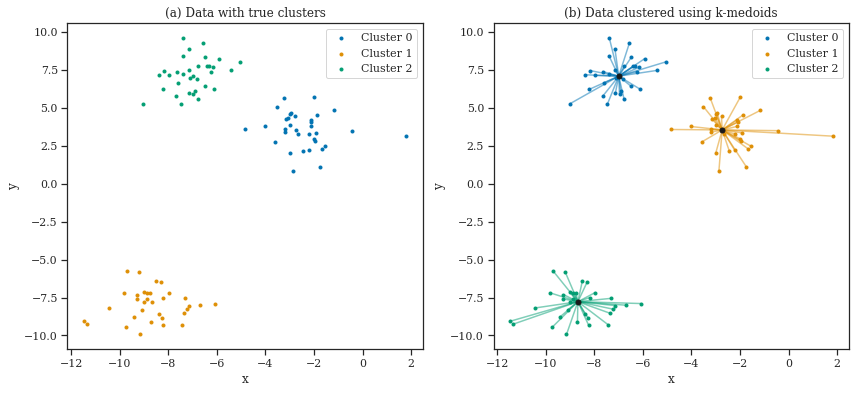

<IPython.core.display.Javascript object>

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot true
for label in range(true_n_clusters):
    point_indices = np.where(clustering_dataset_y == label)[0]

    ax1.scatter(
        x=clustering_dataset_X[point_indices, 0],
        y=clustering_dataset_X[point_indices, 1],
        label=f"Cluster {label}",
        marker=".",
    )
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("(a) Data with true clusters")

# Plot predicted
cluster_instance = KMedoids(n_clusters=true_n_clusters, random_state=rng_seed)
pred_labels = cluster_instance.fit_predict(clustering_dataset_X)
for label, medoid_idx, cluster_color in zip(
    range(true_n_clusters),
    cluster_instance.medoid_indices_,
    sns.color_palette("colorblind").as_hex(),
):
    point_indices = np.where(pred_labels == label)[0]
    point_indices_no_medoid = np.array(
        [idx for idx in point_indices if idx != medoid_idx]
    )

    ax2.scatter(
        x=clustering_dataset_X[point_indices_no_medoid, 0],
        y=clustering_dataset_X[point_indices_no_medoid, 1],
        label=f"Cluster {label}",
        marker=".",
        c=cluster_color,
    )
    for point_idx in point_indices_no_medoid:
        ax2.plot(
            [clustering_dataset_X[point_idx][0], clustering_dataset_X[medoid_idx][0]],
            [clustering_dataset_X[point_idx][1], clustering_dataset_X[medoid_idx][1]],
            c=cluster_color,
            alpha=0.5,
        )
    ax2.scatter(
        x=clustering_dataset_X[medoid_idx, 0],
        y=clustering_dataset_X[medoid_idx, 1],
        marker=".",
        s=100,
        c="k",
        zorder=10,
    )
ax2.legend()
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("(b) Data clustered using k-medoids")

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"k-medoids-clustering-2d-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

### GMM clustering

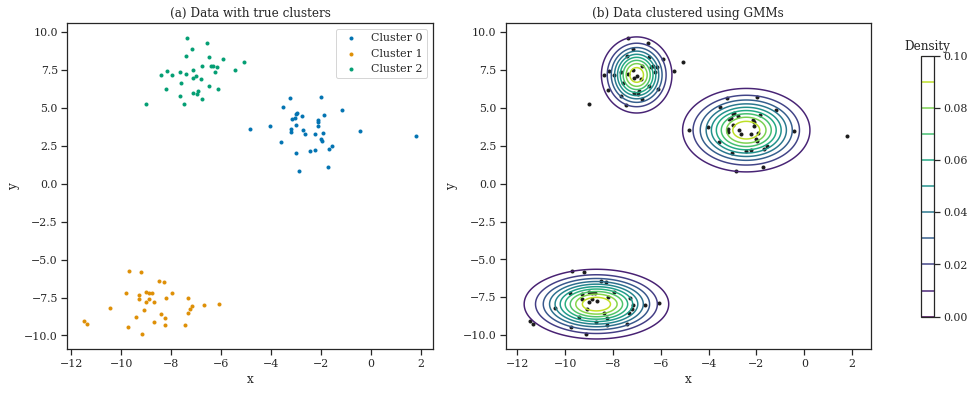

<IPython.core.display.Javascript object>

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Plot true
for label in range(true_n_clusters):
    point_indices = np.where(clustering_dataset_y == label)[0]

    ax1.scatter(
        x=clustering_dataset_X[point_indices, 0],
        y=clustering_dataset_X[point_indices, 1],
        label=f"Cluster {label}",
        marker=".",
    )
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("(a) Data with true clusters")

# Plot predicted
cluster_instance = GaussianMixture(n_components=true_n_clusters, random_state=rng_seed)
cluster_instance.fit(clustering_dataset_X)
ax2.scatter(
    x=clustering_dataset_X[:, 0],
    y=clustering_dataset_X[:, 1],
    marker=".",
    c="k",
)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("(b) Data clustered using GMMs")

# Display predicted scores by the model using contour plots
x = np.arange(
    clustering_dataset_X[:, 0].min() - 1, clustering_dataset_X[:, 0].max() + 1, 0.025
)
y = np.arange(
    clustering_dataset_X[:, 1].min() - 1, clustering_dataset_X[:, 1].max() + 1, 0.025
)
X, Y = np.meshgrid(x, y)
gaussian_2d = lambda x, y, x0, y0, xsig, ysig: (
    1
    / (2 * np.pi * xsig * ysig)
    * np.exp(-0.5 * (((x - x0) / xsig) ** 2 + ((y - y0) / ysig) ** 2))
)
for i in range(true_n_clusters):
    Z = gaussian_2d(
        X,
        Y,
        cluster_instance.means_[i, 0],
        cluster_instance.means_[i, 1],
        cluster_instance.covariances_[i, 0, 0],
        cluster_instance.covariances_[i, 1, 1],
    )
    CS = ax2.contour(X, Y, Z, levels=10, cmap="viridis")

# Add colorbar
cbar = fig.colorbar(CS, ax=[ax1, ax2], location="right", shrink=0.8)
cbar.ax.set_title("Density")

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"k-gmm-clustering-2d-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

### ToMATo clustering

In [9]:
def plot_diagram_tomato(
    tomato_instance: Tomato, ax: plt.axis = None, show_plot: bool = True
) -> None:
    """
    Plots persistence diagram created by ToMATo.

    Parameters
    ----------
    tomato_instance : Tomato
        Trained Tomato instance.
    ax : plt.axis, optional
        Matplotlib axis (defaults to None, i.e. new axis gets created).
    show_plot : bool, optional
        Whether or not to call `plt.show()` (defaults to True).
    """
    if ax is None:
        _, ax = plt.subplots()

    l = tomato_instance.max_weight_per_cc_.min()
    r = tomato_instance.max_weight_per_cc_.max()
    if tomato_instance.diagram_.size > 0:
        ax.plot(tomato_instance.diagram_[:, 1], tomato_instance.diagram_[:, 0], "ro")
        l = min(l, tomato_instance.diagram_[:, 1].min())
        r = max(r, tomato_instance.diagram_[:, 0].max())
    if l == r:
        if l > 0:
            l, r = 0.9 * l, 1.1 * r
        elif l < 0:
            l, r = 1.1 * l, 0.9 * r
        else:
            l, r = -1.0, 1.0
    ax.plot([l, r], [l, r])
    ax.plot(
        np.full(tomato_instance.max_weight_per_cc_.shape, 1.1 * l - 0.1 * r),
        tomato_instance.max_weight_per_cc_,
        "o",
        c="g",
    )
    ax.set_xlabel("Birth")
    ax.set_ylabel("Death")
    if show_plot:
        plt.show()

<IPython.core.display.Javascript object>

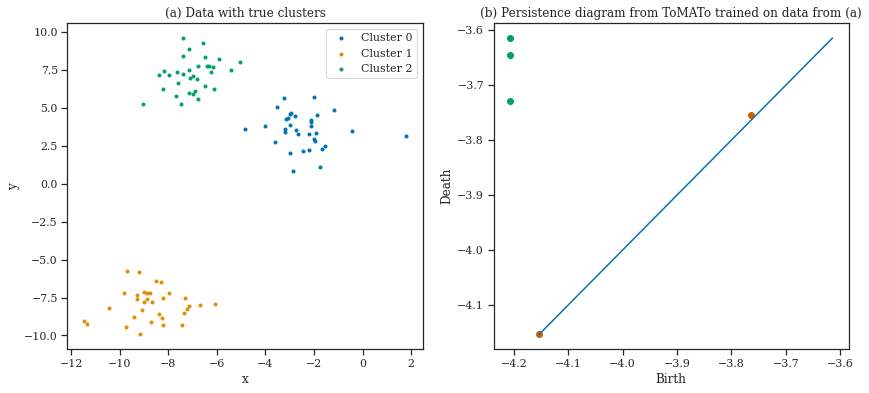

<IPython.core.display.Javascript object>

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot true
for label in range(true_n_clusters):
    point_indices = np.where(clustering_dataset_y == label)[0]

    ax1.scatter(
        x=clustering_dataset_X[point_indices, 0],
        y=clustering_dataset_X[point_indices, 1],
        label=f"Cluster {label}",
        marker=".",
    )
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("(a) Data with true clusters")

cluster_instance = Tomato(graph_type="knn", density_type="logKDE", k=5)
cluster_instance.fit(clustering_dataset_X)
plot_diagram_tomato(cluster_instance, ax=ax2, show_plot=False)
ax2.set_title("(b) Persistence diagram from ToMATo trained on data from (a)")

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"k-tomato-clustering-2d-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Dimensionality reduction

### PCA

In [11]:
# Prepare data
pca_x = np.linspace(-10, 10, 100)
pca_y = pca_x + np.random.normal(scale=3, size=100)
pca_data = np.array([pca_x, pca_y]).T

<IPython.core.display.Javascript object>

In [12]:
def draw_vector(v0, v1, ax) -> None:
    """
    Draws a vector from v0 to v1 on ax.

    Parameters
    ----------
    v0 : np.ndarary
        Start vector.
    v1 : np.ndarary
        End vector.
    ax : plt.axis
        Matplotlib axis.
    """
    arrowprops = dict(arrowstyle="->", linewidth=2, shrinkA=0, shrinkB=0, color="r")
    ax.annotate("", v1, v0, arrowprops=arrowprops)

<IPython.core.display.Javascript object>

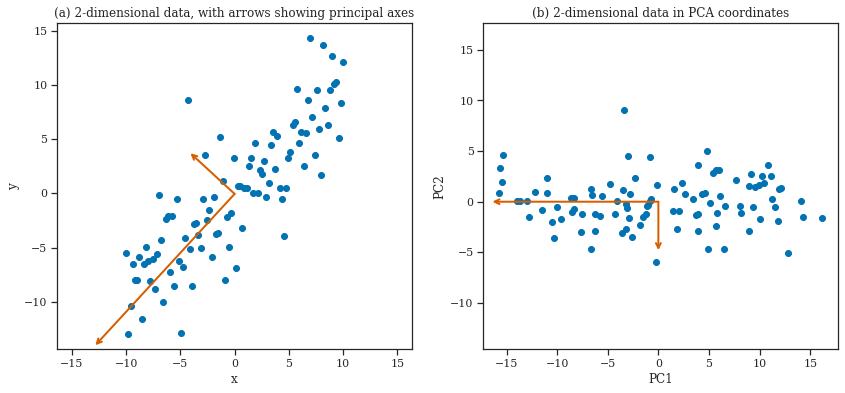

<IPython.core.display.Javascript object>

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

pca = PCA(n_components=2, random_state=rng_seed)
pca.fit(pca_data)
ax1.scatter(x=pca_data[:, 0], y=pca_data[:, 1])
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2.3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax1)
ax1.axis("equal")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("(a) 2-dimensional data, with arrows showing principal axes")

pca_data_transformed = pca.transform(pca_data)
ax2.scatter(x=pca_data_transformed[:, 0], y=pca_data_transformed[:, 1])
pca_cov_mat = pca.components_ * 2.7 * np.sqrt(pca.explained_variance_)
draw_vector([0, 0], [0, pca_cov_mat[0, 1]], ax=ax2)
draw_vector([0, 0], [pca_cov_mat[1, 0], 0], ax=ax2)
ax2.axis("equal")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_title("(b) 2-dimensional data in PCA coordinates")

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"pca-2d-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

### UMAP

In [14]:
# Prepare data
iris_data = load_iris()
iris_data_X = iris_data["data"]
iris_data_y = iris_data["target"]
iris_data_y_names = iris_data["target_names"]

<IPython.core.display.Javascript object>

In [15]:
# Compute UMAP of Iris data
umap = UMAP(n_neighbors=20, n_components=2, random_state=rng_seed)
iris_data_umap = umap.fit_transform(iris_data_X)

<IPython.core.display.Javascript object>

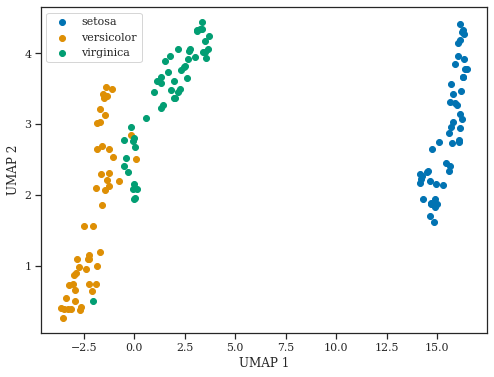

<IPython.core.display.Javascript object>

In [16]:
_, ax = plt.subplots(figsize=(8, 6))

for name, label in zip(iris_data_y_names, np.unique(iris_data_y)):
    point_label_indices = np.where(iris_data_y == label)[0]

    ax.scatter(
        iris_data_umap[point_label_indices, 0],
        iris_data_umap[point_label_indices, 1],
        label=name,
    )
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.legend()

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"umap-2d-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Linear regression

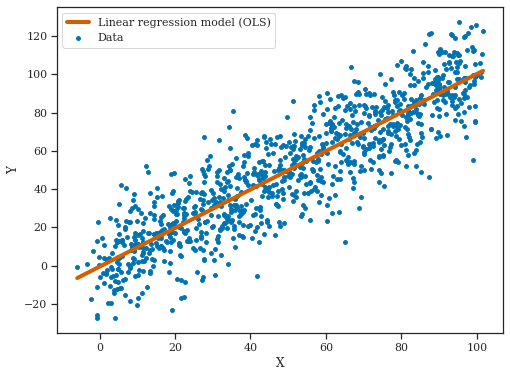

<IPython.core.display.Javascript object>

In [17]:
# Create data
lin_reg_data_x = np.linspace(0, 100, 1000) + np.random.normal(size=1000, scale=2)
lin_reg_data_x_mat = np.array((np.ones_like(lin_reg_data_x), lin_reg_data_x)).T
lin_reg_data_y = lin_reg_data_x + np.random.normal(size=1000, scale=15)

# Plot data
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.scatter(x=lin_reg_data_x, y=lin_reg_data_y, label="Data", c="b", s=15)

# Compute best OLS fit and plot it
[ols_int, ols_slope] = (
    np.linalg.inv(lin_reg_data_x_mat.T @ lin_reg_data_x_mat)
    @ lin_reg_data_x_mat.T
    @ lin_reg_data_y
)
xs = np.linspace(lin_reg_data_x.min(), lin_reg_data_x.max(), 1000)
ax.plot(
    xs,
    ols_int + ols_slope * xs,
    label="Linear regression model (OLS)",
    linewidth=4,
    c="r",
)

# Plot/save
plt.legend()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "linear-regression-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Logistic regression

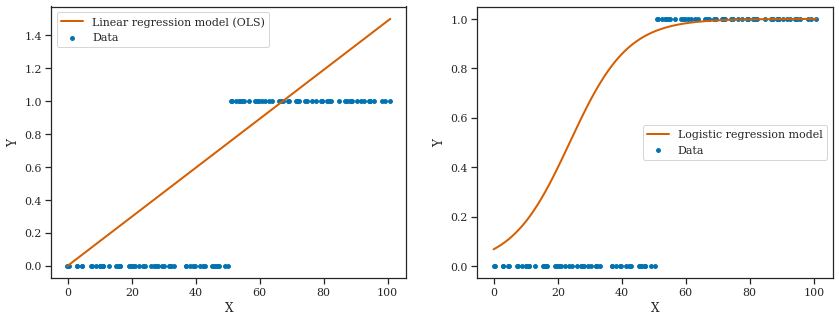

<IPython.core.display.Javascript object>

In [18]:
# Create data
log_reg_data_x = np.concatenate(
    (
        np.linspace(0, 50, 50) + np.random.normal(size=50, scale=1),
        np.linspace(50, 100, 50) + np.random.normal(size=50, scale=1),
    )
)
log_reg_data_x_mat = np.array((np.ones_like(log_reg_data_x), log_reg_data_x)).T
log_reg_data_y = np.concatenate((np.zeros(50, dtype=int), np.ones(50, dtype=int)))

# Compute linear and logistic regression models
lr_model = LinearRegression()
lr_model.fit(X=log_reg_data_x_mat, y=log_reg_data_y)
lr_int, lr_slope = lr_model.coef_
logr_model = LogisticRegression(solver="liblinear")
logr_model.fit(X=log_reg_data_x_mat, y=log_reg_data_y)
logr_int, logr_slope = logr_model.coef_[0]

# Plot linear vs. logistic regression line
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7 * 2, 5))
xs = np.linspace(log_reg_data_x.min(), log_reg_data_x.max(), 1000)
ax1.scatter(x=log_reg_data_x, y=log_reg_data_y, label="Data", s=15)
ax1.plot(
    xs,
    lr_int + lr_slope * xs,
    c="r",
    label="Linear regression model (OLS)",
    linewidth=2,
)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend()
ax2.scatter(x=log_reg_data_x, y=log_reg_data_y, label="Data", s=15)
ax2.plot(
    xs,
    (np.exp(logr_int + logr_slope * xs)) / (1 + np.exp(logr_int + logr_slope * xs)),
    c="r",
    label="Logistic regression model",
    linewidth=2,
)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.legend()

if save_plots_to_file:
    plt.savefig(
        join(output_dir, "logistic-regression-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Plotting common activation functions

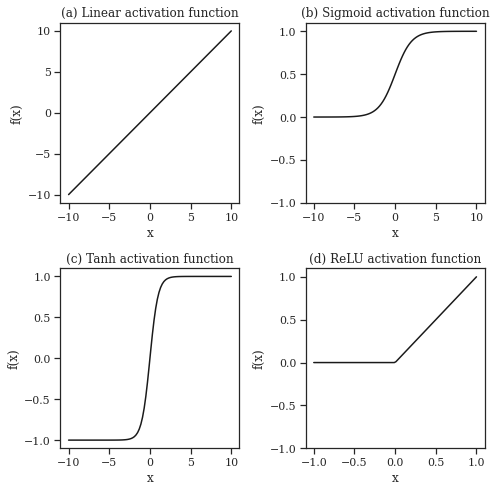

<IPython.core.display.Javascript object>

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))
plot_params = {"c": "k"}

# Linear activation function
xs = np.linspace(-10, 10, 100)
ax1.plot(xs, xs, **plot_params)
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.set_title("(a) Linear activation function")

# Sigmoid activation function
sigmoid = lambda x: 1 / (1 + np.exp(-x))
ax2.set_ylim(-1, 1.1)
ax2.plot(xs, sigmoid(xs), **plot_params)
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.set_title("(b) Sigmoid activation function")

# Tanh activation function
tanh = lambda x: (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
ax3.plot(xs, tanh(xs), **plot_params)
ax3.set_xlabel("x")
ax3.set_ylabel("f(x)")
ax3.set_title("(c) Tanh activation function")

# ReLU activation function
xs = np.linspace(-1, 1, 100)
relu = lambda x: np.maximum(x, 0)
ax4.set_ylim(-1, 1.1)
ax4.plot(xs, relu(xs), **plot_params)
ax4.set_xlabel("x")
ax4.set_ylabel("f(x)")
ax4.set_title("(d) ReLU activation function")

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "common-activation-functions.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Curse of dimensionality

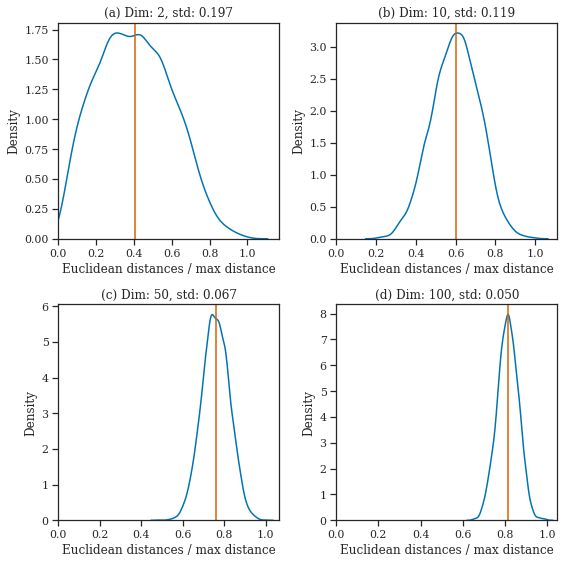

<IPython.core.display.Javascript object>

In [20]:
num_points = 100
cod_dims = [2, 10, 50, 100]
cod_dims_chars = "abcd"
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8, 8),
)
for dims, dim_char, ax in zip(cod_dims, cod_dims_chars, axes.ravel()):

    # Generate points
    points = np.zeros((num_points, dims))
    for dim in range(dims):
        points[:, dim] = np.random.uniform(low=0, high=100, size=num_points)

    # Compute pairwise distances
    points_pairwise_dists = pdist(points)
    points_pairwise_dists_norm = points_pairwise_dists / points_pairwise_dists.max()
    points_pairwise_dists_norm_mean = np.mean(points_pairwise_dists_norm)

    sns.kdeplot(points_pairwise_dists_norm, ax=ax)

    ax.axvline(
        points_pairwise_dists_norm_mean,
        ymin=0,
        ymax=np.max(points_pairwise_dists_norm),
        c="r",
    )
    ax.set_title(
        f"({dim_char}) Dim: {dims}, std: {np.std(points_pairwise_dists_norm):0.3f}",
    )
    ax.set_xlabel("Euclidean distances / max distance")
    ax.set_ylabel("Density")
    ax.set_xlim(left=0)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "curse-of-dimensionality.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Dendrogram example

In [21]:
# Load data
iris_data = load_iris()
iris_data_X = iris_data["data"]
iris_data_y = iris_data["target"]

<IPython.core.display.Javascript object>

In [22]:
# Subsample Iris data to 10 data points per category
iris_data_point_per_cat = 10
iris_data_point_categories = len(np.unique(iris_data_y))
iris_data_X_sub = np.zeros(
    (iris_data_point_per_cat * iris_data_point_categories, iris_data_X.shape[1])
)
iris_data_y_sub = np.zeros(
    iris_data_point_per_cat * iris_data_point_categories, dtype=int
)
for label_i in range(3):
    iris_data_point_indices = np.where(iris_data_y == label_i)[0][
        :iris_data_point_per_cat
    ]
    iris_data_X_sub[
        iris_data_point_per_cat * label_i : iris_data_point_per_cat * (label_i + 1)
    ] = iris_data_X[iris_data_point_indices]
    iris_data_y_sub[
        iris_data_point_per_cat * label_i : iris_data_point_per_cat * (label_i + 1)
    ] = iris_data_y[iris_data_point_indices]

<IPython.core.display.Javascript object>

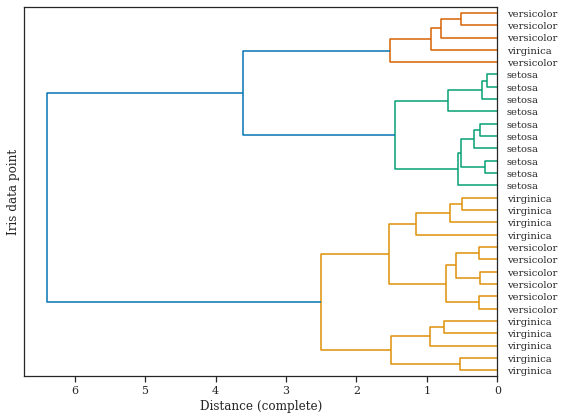

<IPython.core.display.Javascript object>

In [23]:
# Compute ward linkage on Iris data
iris_data_linkage = linkage(iris_data_X_sub, method="complete")
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("Distance (complete)")
ax.set_ylabel("Iris data point")
dendrogram(
    Z=iris_data_linkage,
    labels=[iris_data["target_names"][y] for y in iris_data_y_sub],
    color_threshold=3,
    orientation="left",
    ax=ax,
)

# Plot/save
plt.tight_layout()
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "dendrogram-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

# HDBSCAN example

In [24]:
# Load data
iris_data = load_iris()
iris_data_X = iris_data["data"]
iris_data_y = iris_data["target"]

<IPython.core.display.Javascript object>

In [25]:
hdbscan_ins = HDBSCAN(min_cluster_size=3)
hdbscan_ins.fit(iris_data_X)

HDBSCAN(min_cluster_size=3)

<IPython.core.display.Javascript object>

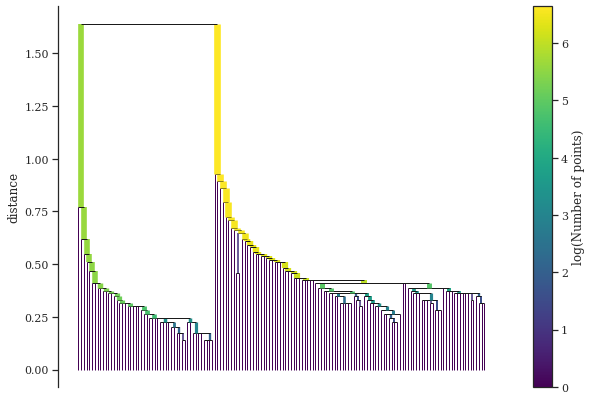

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
hdbscan_ins.single_linkage_tree_.plot(axis=ax)

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "hdbscan-single-linage-tree-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

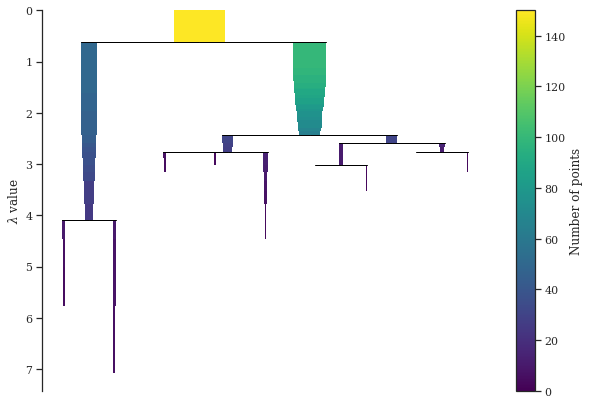

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))
hdbscan_ins.condensed_tree_.plot(axis=ax, select_clusters=False)

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "hdbscan-condensed-tree-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

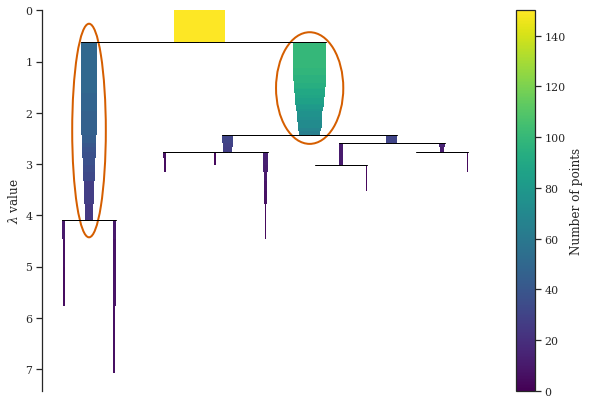

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(figsize=(10, 7))
hdbscan_ins.condensed_tree_.plot(axis=ax, select_clusters=True)

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, "hdbscan-condensed-tree-final-cut-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()

## Gradient descent

In [29]:
# Perform GD
grad_f_x_y = lambda x, y: np.array([2 * x - 4, 2 * y - 8])
gd_iters = 100
gd_lr = 0.1
current_point = np.array([-5, -10])
gd_points = [current_point]
for i in range(gd_iters):
    current_point = current_point - gd_lr * grad_f_x_y(*current_point)
    gd_points.append(current_point)
gd_points = np.array(gd_points)

<IPython.core.display.Javascript object>

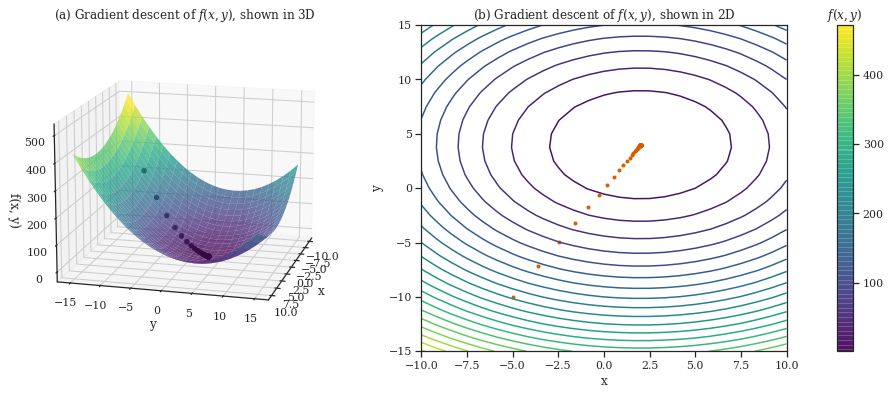

<IPython.core.display.Javascript object>

In [30]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2)

gd_X, gd_Y = np.meshgrid(
    np.linspace(-10, 10, 25),
    np.linspace(-15, 15, 25),
)
f_x_y = lambda x, y: (x - 2) ** 2 + (y - 4) ** 2
gd_Z = f_x_y(gd_X, gd_Y)
surface_handle = ax1.plot_surface(
    gd_X, gd_Y, gd_Z, cmap="viridis", linewidth=0, alpha=0.75
)
ax1.scatter(
    xs=gd_points[:, 0],
    ys=gd_points[:, 1],
    zs=[f_x_y(gd_x, gd_y) for gd_x, gd_y in gd_points],
    alpha=1,
    c="k",
)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel(r"f(x, y)")
ax1.set_title(r"(a) Gradient descent of $f(x, y)$, shown in 3D")
ax1.azim = 15
ax1.elev = 15

ax2.contour(gd_X, gd_Y, gd_Z, levels=20, cmap="viridis")
ax2.scatter(x=gd_points[:, 0], y=gd_points[:, 1], c="r", marker=".")
ax2.set_title(r"(b) Gradient descent of $f(x, y)$, shown in 2D")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

clb = fig.colorbar(surface_handle, ax=[ax1, ax2], location="right")
clb.ax.set_title(r"$f(x, y)$")

# Plot/save
if save_plots_to_file:
    plt.savefig(
        join(output_dir, f"gradient-descent-example.pdf"),
        backend="pgf",
        bbox_inches="tight",
    )
else:
    plt.show()